# V-H (AC measurements) for different $\theta$
# $H_{sw} - \theta$ 


In [4]:
# load Packages & Settings
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
import os
%matplotlib inline
# set fonts
font = {'family' : 'Sans',
        'weight' : 'bold',
        'size'   : 8}
rc('font', **font)

In [1]:
# get files from rootdir with specific suffix
def get_files(rootdir, suffix):
    file_list = []
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if file.endswith(suffix):
                file_list.append(os.path.join(subdir, file))
    file_list.sort(key=lambda x: os.path.getmtime(x)) # sort file by time
    return file_list

# load data from file and return it as numpy-array
def load_data(filename):
    arr = []
    for line in [line for line in open(filename, 'r')]:
        temp = [float(element) for element in line.split(',')] # parse each line and convert to floating
        temp =  np.array(temp[10:]) # dump the first M points
        temp.reshape(-1,1) # shape into columns
        arr.append(temp)
    del temp
    return np.array(arr)

# Normalize 1D data set to the range of [lo, hi]
def Normalize1D(x, lo, hi):
    # this works only for 1D data x
    return (hi - lo)*((x - min(x))/(max(x) - min(x)))-(hi - lo)/2.0

def search_jump(x, angle):
    if(angle <= 90):
        # find max for downward jump
        return np.argmin(x)
    elif(angle > 90):
        # find min for upward jump
        return np.argmax(x)
 

In [ ]:
   
# traverse to the target directory, load filenames and sort them by time.
rootdir = "/Users/yiyi/Desktop/LiorDataAnalysis/Hsw-Angle/DoubleCheck/45degree_together"
os.chdir(rootdir)

file_list = get_files(rootdir, '.txt')
# plot out V-H for different angles
Angle_Hsw = ['Angle', 'Hsw']
# angle_list = np.linspace(0, 31, 32)*3.6 + 120
i = 0
for file in file_list:
    angle = float(file.split('_')[1].split('Degree')[0]) # get angle in degree from filename
#     angle = angle_list[i]
    data = load_data(file)
    
    fig = plt.figure(figsize=(12, 8), dpi=300)
    f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey = False)
    ax1.grid(False)
    ax2.grid(False)
    cumV = np.cumsum((Normalize1D(data[1, :], -1, 1)))
    index_jump = search_jump(cumV, angle)
    width = 10
    index_jump = search_jump(cumV[index_jump-width:index_jump+width], angle) + index_jump - width
#     ax1.plot(data[0, :], np.cumsum(Normalize1D(data[1, :], -1, 1)), color='r', label='cumsum')
    ax2.plot(data[0, :], data[1, :], color='b', label='V')
    ax2.plot(data[0, index_jump], data[1, index_jump], 'c+', markersize=25)
    ax1.set_xlim([-4, -2])
    ax2.set_xlim([-4,-2])
    f.text(0.5, 0.9, '$H-V_{xy}, \Theta=$' + str(angle) + ' degree', ha='center', fontsize=16)
    f.text(0.5, 0.04, 'H(Oe)', ha='center', fontsize=12)
    f.text(0.04, 0.5, '$V_{xy} (\mu V)$', va='center', rotation='vertical', fontsize=12)
    plt.savefig(file[:-4] + '.png', dpi=300)
    Angle_Hsw.append([angle, data[0, index_jump]])
    plt.show()
    i = i + 1
print('Kale!')
result = np.array(Angle_Hsw)
np.savetxt("Angle-Hsw-04.csv", Angle_Hsw, delimiter=",")
plt.close("all")

In [14]:
file_list

['/Users/yiyi/Desktop/LiorDataAnalysis/Hsw-Angle/DoubleCheck/45degree_together/neg_45.0Degree.txt',
 '/Users/yiyi/Desktop/LiorDataAnalysis/Hsw-Angle/DoubleCheck/45degree_together/pos_45Degree.txt']

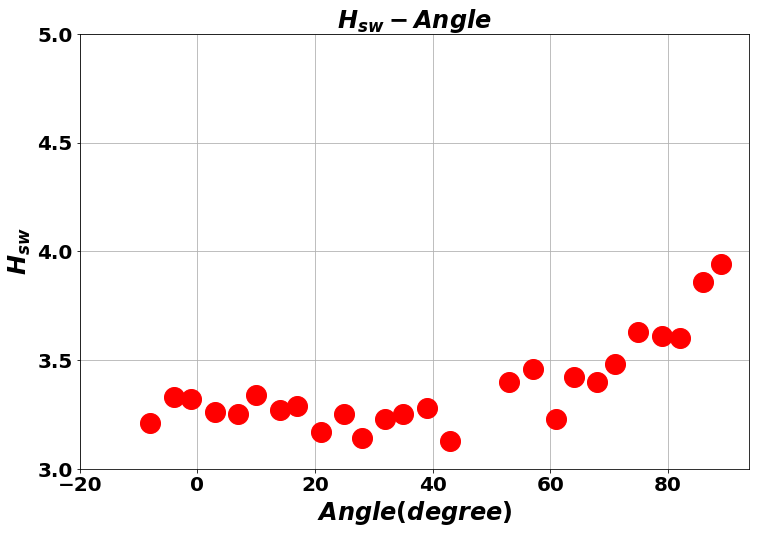

In [108]:
data = pd.read_csv("Angle-Hsw-04.csv")
fig = plt.figure(figsize=(12, 8))
plt.grid(True)
plt.plot(data['Angle']-135, abs(data['Hsw']), 'ro', markersize=20)
plt.xlabel('$Angle (degree)$', fontsize=24)
plt.xticks(np.linspace(-20, 80,6), fontsize=20)
plt.yticks(np.linspace(3.0, 5.0, 5), fontsize=20)
plt.ylabel('$H_{sw}$', fontsize=24)
plt.ylim(3,5)
# plt.xlim(120, 240)
plt.title('$H_{sw} - Angle$', fontsize=24)
plt.show()

In [ ]:
rootdir = "/Users/yiyi/Desktop/LiorDataAnalysis"
os.chdir(rootdir)

file_list = []
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if file.endswith('.txt'):
            file_list.append(os.path.join(subdir, file))
file_list.sort(key=lambda x: os.path.getmtime(x)) # sort file by time

smooth_points = 10 # numbers of points to be smooth
LabelX = '$time(\mu s)$'
LabelLeftY = '$V_{34}$'
LabelRightY = '$V_{12}$'
TitleName = '$V^{Hall} - time$'
TimeWindows = 20 # \micro s points on both side from the center.
TimeWindows = TimeWindows*1e-6 
ymin = -1.2
ymax = 1.2
extra_edge = 0.1
cutoff = 0.20 # 95% and 5% cutoff for transition time measurements
epsilon = 5.0e-3 # tolerance for searching, 2 mV in this case.

#########################################
Ht = []
# df.to_csv("Ht.csv")

for i in range(0, len(file_list)-1, 2):
    ###########
    ## Show current working process
    fig = plt.figure(figsize = (10, 20), facecolor=[1, 1, 1], dpi=100)


    print('Task process:', i/2 + 1, '/', len(file_list)/2, 'complete')
    print('current working file: \n', file_list[i], '\n', file_list[i+1])
    
    ## Setup figure specifications
    plotX1, axarr = plt.subplots(2)
    plt.locator_params(nticks=5)
    plotX1.subplots_adjust(right=0.9, left=0.1, top=0.9, bottom=0.15)
    fig.text(0.0, 0.5, 'common Y', va='center', rotation='vertical')
    plt.locator_params(axis='y', nticks=5)
    ax1 = axarr[0]
    ax3 = axarr[1]
    

    # get the switching field in Oe from the filename, load data, and calculate cumV1
    Hsw = -1.0*float(file_list[i].split('--')[1].split('Oe')[0]) # switching field in Oe
    Itop = float(file_list[i].split('Oe_')[1].split('mA')[0]) # top current in mA
    
    t10, dt1, t1, V1, normalV1 = load_data(file_list[i], smooth_points)
    cumV1 = np.cumsum(normalV1)
    
    # find the max point in the cumsum of V1, in the case of TimeWindows overflow the left or the right
    IndexMax1 = np.argmax(cumV1)
    TimeCenter1 = t1[IndexMax1]
    if((IndexMax1 - TimeWindows/(2*dt1) < 0) or (IndexMax1 + TimeWindows/(2*dt1) >= len(t1))):
        IndexLeft = 0
        IndexRight = -1
        TimeLeft1 = t1[0]
        TimeRight1 = t1[-1]
        IndexMax1 = int(len(t1)/2)
        TimeCenter = t1[IndexMax1]
    
    else:
        TimeLeft1 = t1[IndexMax1 - int(TimeWindows/(2*dt1))]
        TimeRight1 = t1[IndexMax1 + int(TimeWindows/(2*dt1))]
        IndexLeft = IndexMax1 - int(TimeWindows/(2*dt1))
        IndexRight = IndexMax1 + int(TimeWindows/(2*dt1))
        
    Vmax1 = Normalize(cumV1, -1.0, 1.0)[IndexMax1]        
    
    ####
    # get local data Ydata[TimeLeft1, TimeRight1]
    dividend = 4
    t1_local = t1[IndexLeft:IndexRight]
    V1_local = V1[IndexLeft:IndexRight]
    
    # get the Left, Mid, Right 
    t1Left = t1[IndexLeft:IndexMax1 - int(TimeWindows/(dividend*dt1))]
    t1Mid = t1[IndexMax1 - int(TimeWindows/(dividend*dt1)):IndexMax1 + int(TimeWindows/(dividend*dt1))]
    t1Right = t1[IndexMax1 + int(TimeWindows/(dividend*dt1)):IndexRight]
    
    V1Left = V1[IndexLeft:IndexMax1 - int(TimeWindows/(dividend*dt1))]
    V1Mid = V1[IndexMax1 - int(TimeWindows/(dividend*dt1)):IndexMax1 + int(TimeWindows/(dividend*dt1))]
    V1Right = V1[IndexMax1 + int(TimeWindows/(dividend*dt1)):IndexRight]
    
    MeanLeft = np.mean(V1Left)
    MeanRight = np.mean(V1Right)
    Top95 = MeanRight + (MeanLeft - MeanRight)*(1-cutoff)
    Bot05 = MeanRight + (MeanLeft - MeanRight)*cutoff
    
    t1LeftEnd = t1[IndexMax1 - int(TimeWindows/(dividend*dt1))]
    t1RightEnd = t1[IndexMax1 + int(TimeWindows/(dividend*dt1))]
    
    ax3.axhline(y=MeanRight, color ='k',linewidth=1, linestyle='-')
    ax3.axhline(y=MeanLeft, color ='k',linewidth=1, linestyle = '-')
    ax3.axhline(y=Top95, color ='r',linewidth=2, linestyle='--')
    ax3.axhline(y=Bot05, color ='c',linewidth=2, linestyle = '--')
    
    ##
    # traverse from the center to the left, right to find the 95%, 5% position.
    t1LeftTemp = t1[IndexMax1 - int(TimeWindows/(dividend*dt1)):IndexMax1]
    V1LeftTemp = V1[IndexMax1 - int(TimeWindows/(dividend*dt1)):IndexMax1]
    t1LeftBlock = t1LeftTemp[::-1] # Reverse the array 
    V1LeftBlock = V1LeftTemp[::-1]  # reverse the array
    t1RightBlock = t1[IndexMax1: IndexMax1 + int(TimeWindows/(dividend*dt1))] # no need to reverse the right block
    V1RightBlock = V1[IndexMax1: IndexMax1 + int(TimeWindows/(dividend*dt1))] # no need to reverse the right block
    
    ## 
    # Search Lineary the Left and Right blocks for the 5% and 95% part with tolerance of 1.0e-3,
    # break out of loop once target found
    
    Index95, val95 = search_value(V1LeftBlock, Top95, epsilon)
    Index05, val05 = search_value(V1RightBlock, Bot05, epsilon)
    t_center = (t1RightBlock[Index05]-t1LeftBlock[Index95])/2+t1LeftBlock[Index95]

    ax3.axvline(x=t1LeftBlock[Index95], color ='r',linewidth=2, linestyle='--')
    ax3.axvline(x=t1RightBlock[Index05], color ='c',linewidth=2, linestyle = '--')
    
    #########################################
    ax1.axvline(x=t_center, color='g',linewidth=2) # re-center 
    ax1.plot(t1, V1,'b.', markersize = 1)
    ax1.set_xlabel(LabelX)
    ax1.set_ylabel(LabelLeftY, color='b')
    ax1.tick_params('y', colors='b')
    ax1.locator_params(axis='y', nticks=4)
    ax1.set_ylim(min(V1) - (max(V1) - min(V1))*extra_edge, max(V1) + (max(V1) - min(V1))*extra_edge)
    
    
    ax3.axvline(x= t_center, color ='g',linewidth=2) # re-center
    ax3.plot(t1_local, V1_local, 'b.', markersize = 1)
    ax3.set_ylabel(LabelLeftY + '-zoom', color = 'b')
    ax3.tick_params('y', colors='b', width=2)
    ax3.set_ylim(min(V1) - (max(V1) - min(V1))*extra_edge, max(V1) + (max(V1) - min(V1))*extra_edge)
    ax3.locator_params(axis='y', nticks=4)
    ax3.locator_params(axis='x', nticks=4)
    ax3.set_xlim(TimeLeft1, TimeRight1)
    ax3.set_xlabel('$time(\mu s)$', fontsize=10)
    #########################################
    
    ### calculate delay and velocity, put it into the title of the image.
    delay = t1RightBlock[Index05] - t1LeftBlock[Index95] # in us
    Ht.append([Itop, Hsw, delay])
    finalTitle = '$H_{sw}=$' + str(round(Hsw, 3)) + '$Oe, I=$' + str(Itop) + '$mA, \Delta t =$' + str(round(delay, 3)) +  '$\mu s$'
    plt.suptitle(finalTitle, fontsize=14)
    plt.grid(False)
    plt.savefig(file_list[i][:-4] + '-2080.png', dpi=300)
    plt.show()
print('Kale!')
np.savetxt("I_Hsw_trans-2080.csv", Ht, delimiter=",")
plt.close("all")



In [35]:
# load data from filepath and return it as numpy-array
def load_data(filepath, mode, delimiter):
    arr = []
    # read data line by line and parse it into an array  
    for line in open(filepath, mode):
        # parse each line and convert to floating
        current_line = np.array([float(element) for element in line.split(delimiter)]) 
        # append current_line to arr column by column
        arr.append(current_line.reshape(-1, 1)) 
    return np.array(arr)

# search a target value with error no greater than epsilon
# def search_target(arr1D, target, epsilon):
#     index = 
#     result = np.nan
#     for ind, val in enumerate(arr1D):
#         if(abs(val - target) <= epsilon):
#             index = ind
#             result = val
#             break
#     return index, result

# def search_value(array1D, target, startIndex, endIndex, searchDirection, epsilon):
#     index = startIndex
#     result = -1
#     for ind, val in enumerate(arr1D):
#         if(abs(val - target) <= epsilon):
#             index = ind
#             result = val
#             break # once a value is found, break out of the condition-loop
#     return index, result

In [40]:
# load data from file and return it as numpy-array
def load_data(filename):
    arr = []
    for line in [line for line in open(filename, 'r')]:
        temp = [float(element) for element in line.split(',')] # parse each line and convert to floating
        temp =  np.array(temp[10:]) # dump the first M points
        temp.reshape(-1,1) # shape into columns
        arr.append(temp)
    del temp
    return np.array(arr)

# normalize data into the range of [lo, hi]
def Normalize(x, lo, hi):
    return (hi - lo)*((x - min(x))/(max(x) - min(x)))-(hi - lo)/2.0

# search a target value with error no greater than epsilon
def search_value(ArrIn, Target, epsilon):
    index = 0
    result = -1
    for ind, val in enumerate(ArrIn):
        if(abs(val - Target) <= epsilon):
            index = ind
            result = val
            break
    return index, result

## Implement the Edge and location finder function

In [ ]:
# functions for normalization, loading data, smoothing
# Normalize data to [-1.0, 1.0]

def Normalize(x, lo, hi):
    return (hi - lo)*((x - min(x))/(max(x) - min(x)))-(hi - lo)/2.0

def load_data(filename, smooth_points):
    all_lines = [line for line in open(filename, 'r')]
    
    #### get parameters from the head of the txt file
    T0 = float(all_lines[18].split('\t')[1])  # T0 is the starting time in second   
    Delta_T = float(all_lines[19].split('\t')[1])  # step of time in second
    
    Y_str = all_lines[22:]     # all Ystr = [t, Y] starting from 22 
    ## get Y from Y_str
    Ydata = []
    for element in Y_str[:-2]:
        Ydata.append(float(element.split('\t')[1]))
    Ydata = np.array(Ydata)
    
    # normalize the data to -1.0 and +1.0
    NormalYdata = Normalize(Ydata, -1.0, 1.0)
    
    # create Time Series
    T = np.linspace(T0 , T0 + Delta_T*len(Ydata), num = len(Ydata))*1e6
    return T0, Delta_T, T, Ydata, NormalYdata
#     return T0, Delta_T, T, smooth(Ydata, smooth_points), smooth(NormalYdata, smooth_points)

# Search array for a target value with tolerance epsilon
def search_value(ArrIn, Target, epsilon):
    index = 0
    result = -1
    for ind, val in enumerate(ArrIn):
        if(abs(val - Target) <= epsilon):
            index = ind
            result = val
            break
    return index, result

# smooth data y with number of points
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth   